In [83]:
import importlib
import logging

import dask.dataframe as dd
import numpy as np
import pandas as pd
import scipy.stats

import helpers
from helpers.pseudobulk_evaluation import deg_analysis

In [2]:
import warnings

warnings.filterwarnings("ignore")

helpers.logging.configure_logging()
logging.getLogger("gcsfs").setLevel("INFO")
logging.getLogger("google.cloud.bigquery").setLevel("DEBUG")
logging.getLogger("helpers").setLevel("DEBUG")
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")

In [3]:
ddf_bulk_rnaseq_tcga_skcm = dd.read_parquet(
    "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet",
    engine="pyarrow",
)
ddf_bulk_rnaseq_pseudobulks = (
    dd.read_parquet(
        "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet",
        engine="pyarrow",
    )
    .replace({"malignant_from_one_sample": {"True": True, "False": False}})
    .astype({"n_cells": "uint8", "malignant_from_one_sample": "bool"})
    .rename(columns={"tcga_aliquot_barcode_for_fractions": "aliquot_barcode"})
)
df_sample_metadata = deg_analysis.get_tcga_skcm_metastatic_sample_metadata()
df_gene_stats_tcga_skcm = deg_analysis.compute_all_deg_results(
    ddf_bulk_rnaseq_tcga_skcm, df_sample_metadata
)
df_gene_stats_pseudobulks = deg_analysis.compute_all_deg_results(
    ddf_bulk_rnaseq_pseudobulks, df_sample_metadata
)

2022-07-22 15:25:42,790 80465/MainThread helpers.datasets DEBUG
loading TCGA SKCM fractions estimated by CIBERSORTx
Downloading:   0%|          | 0/369 [00:00<?, ?rows/s]2022-07-22 15:25:45,669 80465/MainThread google.cloud.bigquery._pandas_helpers DEBUG
Started reading table 'keen-dispatch-316219._f3d6852d3dddd53ba7361e949c2756f4d2d034c2.anon963500c015ce7e85114c37e4791af2a8546dee82' with BQ Storage API session 'projects/keen-dispatch-316219/locations/us/sessions/CAISDEgySW5naTBXS3BHdBoCamYaAmpk'.
Downloading: 100%|██████████| 369/369 [00:01<00:00, 279.33rows/s]
2022-07-22 15:25:46,193 80465/MainThread helpers.pseudobulk_evaluation.deg_analysis DEBUG
computing stats
2022-07-22 15:25:59,128 80465/MainThread helpers.pseudobulk_evaluation.deg_analysis DEBUG
creating derived columns (e.g. -log10_pval...)
2022-07-22 15:25:59,135 80465/MainThread helpers.pseudobulk_evaluation.deg_analysis DEBUG
computing B-H significance test manually for alpha=0.05
2022-07-22 15:25:59,353 80465/MainThread h

In [ ]:
df_gene_stats_merged = df_gene_stats_tcga_skcm.merge(
    df_gene_stats_pseudobulks,
    on="gene_symbol",
    l_suffix="_tcga_skcm",
    r_suffix="_pseudobulks",
)

In [4]:
df_gene_stats_tcga_skcm.info(), df_gene_stats_pseudobulks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16063 entries, 0 to 16062
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   gene_symbol                          16063 non-null  category
 1   pval                                 16063 non-null  float64 
 2   fold_change                          16063 non-null  float64 
 3   -log10_pval                          16063 non-null  float64 
 4   log2_fold_change                     16063 non-null  float64 
 5   -log10_pval_signed                   16063 non-null  float64 
 6   pval_adj_bh                          16063 non-null  float64 
 7   -log10_pval_adj_bh                   16063 non-null  float64 
 8   -log10_pval_adj_bh_signed            16063 non-null  float64 
 9   pval_rank_pandas                     16063 non-null  float64 
 10  pval_adj_rank_pandas                 16063 non-null  float64 
 11  -log10_pval_adj

(None, None)

# plots

In [5]:
import plotly.express as px

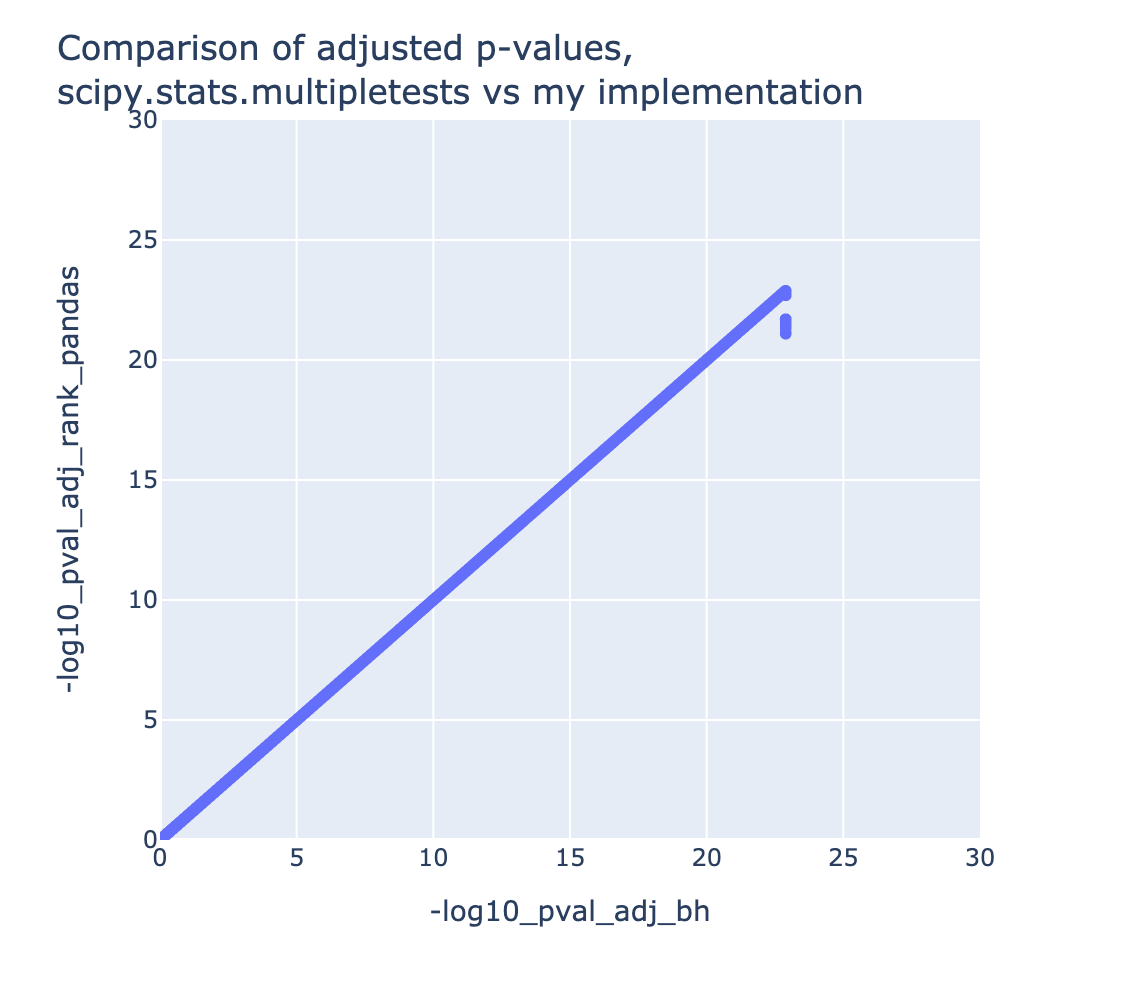

In [10]:
fig = px.scatter(
    df_gene_stats_tcga_skcm[
        [
            "gene_symbol",
            "-log10_pval_adj_bh",
            "-log10_pval_adj_rank_pandas",
            "pval_rank_pandas",
        ]
    ],
    x="-log10_pval_adj_bh",
    y="-log10_pval_adj_rank_pandas",
    hover_data=["pval_rank_pandas"],
    hover_name="gene_symbol",
)
fig = fig.update_layout(
    title="Comparison of adjusted p-values, <br>scipy.stats.multipletests vs my implementation",
)
fig = fig.update_xaxes(range=(0, 30))
fig = fig.update_yaxes(range=(0, 30))
fig.show(renderer="png", width=570, height=500, scale=2)

In [12]:
df_gene_stats_tcga_skcm

,gene_symbol,pval,fold_change,-log10_pval,log2_fold_change,-log10_pval_signed,pval_adj_bh,-log10_pval_adj_bh,-log10_pval_adj_bh_signed,pval_rank_pandas,pval_adj_rank_pandas,-log10_pval_adj_rank_pandas,significant_bh_fdr=0.05,significant_bh_fdr=0.05_rank_pandas,significant_bh_fdr=0.10,significant_bh_fdr=0.10_rank_pandas,significant_bh_fdr=0.20,significant_bh_fdr=0.20_rank_pandas
0,A1BG,2.760504e-03,0.749164,2.559012,-0.416646,-2.559012,7.757520e-03,2.110277,-2.110277,5710.0,7.765671e-03,2.109821,True,True,True,True,True,True
1,A2M,2.658208e-03,1.324988,2.575411,0.405979,2.575411,7.493647e-03,2.125307,2.125307,5689.0,7.505502e-03,2.124620,True,True,True,True,True,True
2,A2ML1,7.338630e-02,2.437467,1.134385,1.285382,1.134385,1.275043e-01,0.894475,0.894475,9245.0,1.275072e-01,0.894465,False,False,False,False,True,True
3,A4GALT,1.673329e-09,2.291428,8.776419,1.196247,8.776419,1.563623e-08,7.805868,7.805868,1717.0,1.565444e-08,7.805362,True,True,True,True,True,True
4,A4GNT,5.205548e-01,1.056338,0.283534,0.079072,0.283534,6.214609e-01,0.206586,0.206586,13438.0,6.222408e-01,0.206042,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16058,ZYG11A,1.032366e-06,1.179268,5.986166,0.237892,5.986166,6.588360e-06,5.181223,5.181223,2517.0,6.588360e-06,5.181223,True,True,True,True,True,True
16059,ZYG11B,2.216201e-02,0.852496,1.654391,-0.230235,-1.654391,4.653444e-02,1.332226,-1.332226,7639.0,4.660144e-02,1.331601,True,True,True,True,True,True
16060,ZYX,1.142813e-09,1.302782,8.942025,0.381596,8.942025,1.086213e-08,7.964085,7.964085,1690.0,1.086213e-08,7.964085,True,True,True,True,True,True
16061,ZZEF1,5.900124e-01,1.006465,0.229139,0.009297,0.229139,6.847811e-01,0.164448,0.164448,13827.0,6.854249e-01,0.164040,False,False,False,False,False,False


# plots

Differential gene expression, immune high / low<br>Data: real bulk RNA-seq (TCGA SKCM)


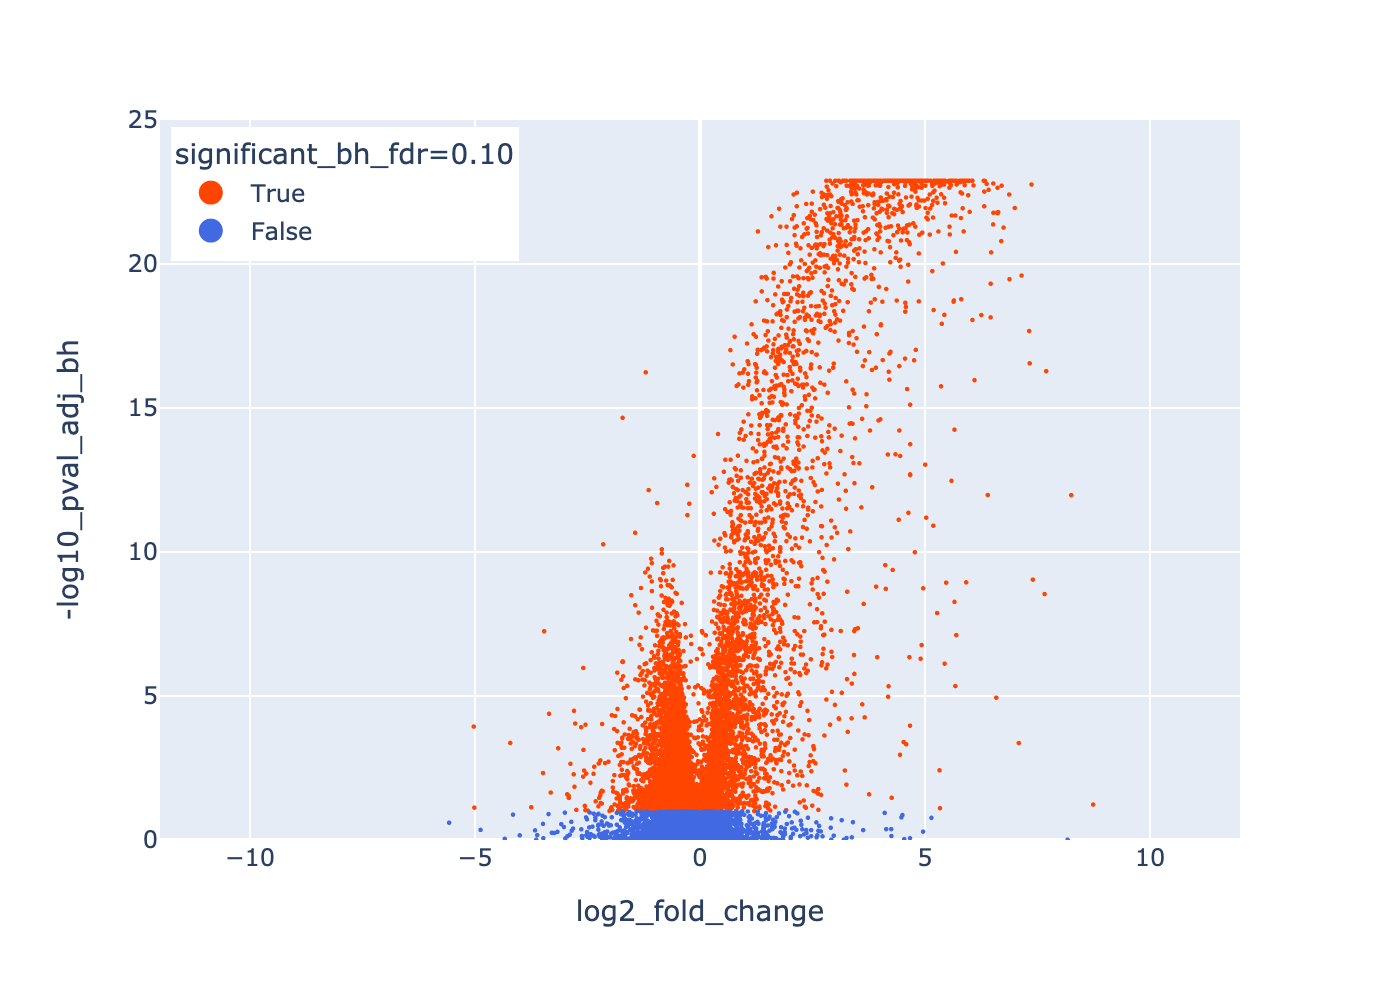

In [123]:
import importlib

importlib.reload(deg_analysis)

title = (
    "Differential gene expression, immune high / low"
    "<br>Data: real bulk RNA-seq (TCGA SKCM)"
)
fig = deg_analysis.make_volcano_plot(df_gene_stats_tcga_skcm)

print(title)

fig.show(renderer="png", scale=2, width=700, height=500)

Differential gene expression, immune high / low<br>Data: pseudobulk RNA-seq


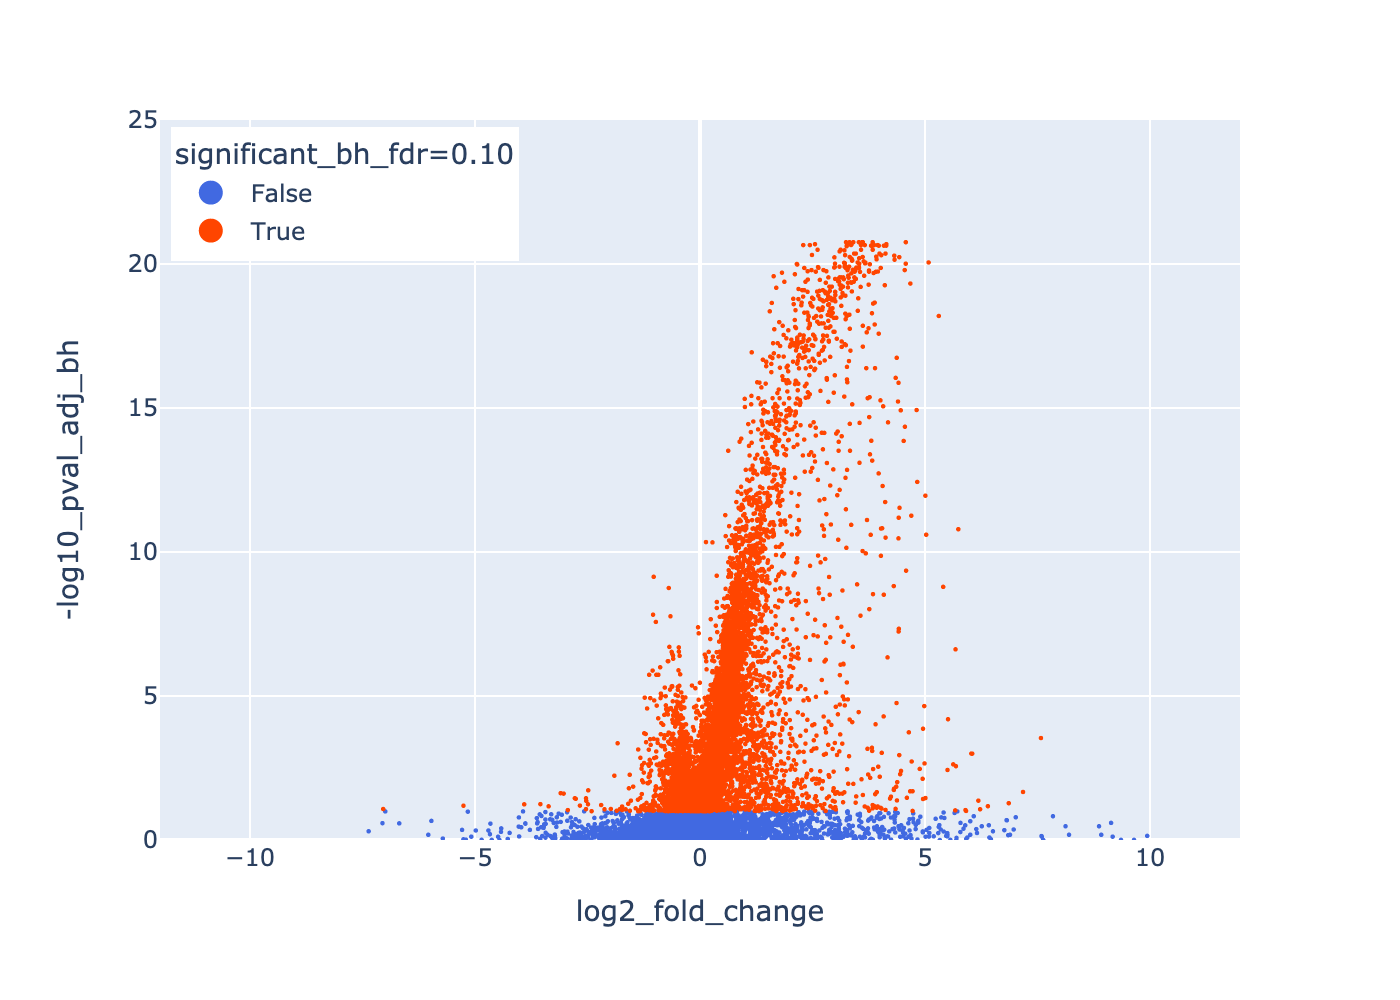

In [124]:
import importlib

importlib.reload(deg_analysis)

title = "Differential gene expression, immune high / low" "<br>Data: pseudobulk RNA-seq"
fig = deg_analysis.make_volcano_plot(df_gene_stats_pseudobulks)

print(title)

fig.show(renderer="png", scale=2, width=700, height=500)

Scatter plot of FDR-corrected DEG p-values, comparing pseudobulks vs tcga skcm bulk RNA-seq


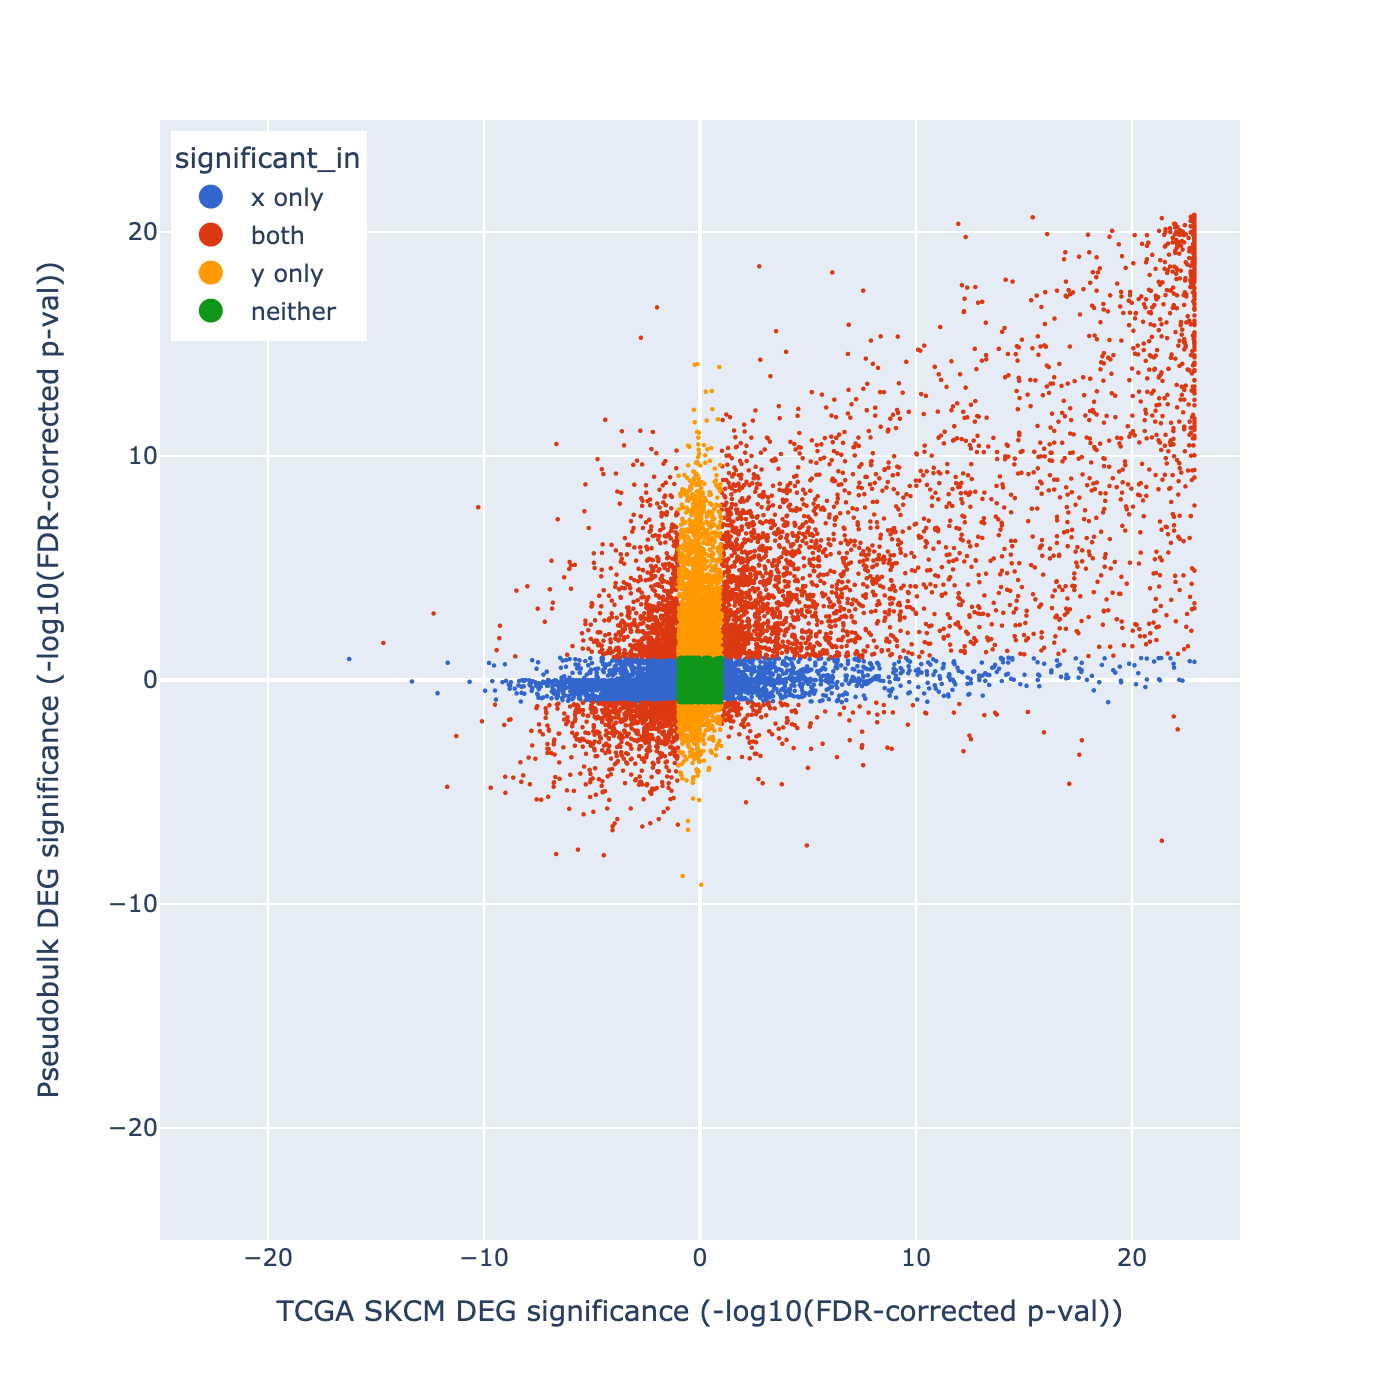

In [166]:
importlib.reload(deg_analysis)

title = "Scatter plot of FDR-corrected DEG p-values, comparing pseudobulks vs tcga skcm bulk RNA-seq"
fig = deg_analysis.make_scatter_of_signed_pvals(df_gene_stats_merged)

fig.update_layout(
    # title=title,
    xaxis_title="TCGA SKCM DEG significance (-log10(FDR-corrected p-val))",
    yaxis_title="Pseudobulk DEG significance (-log10(FDR-corrected p-val))",
)

print(title)

fig.show(renderer="png", scale=2, width=700, height=700)

Scatter plot of gene expression fold changes: pseudobulks vs tcga skcm bulk RNA-seq


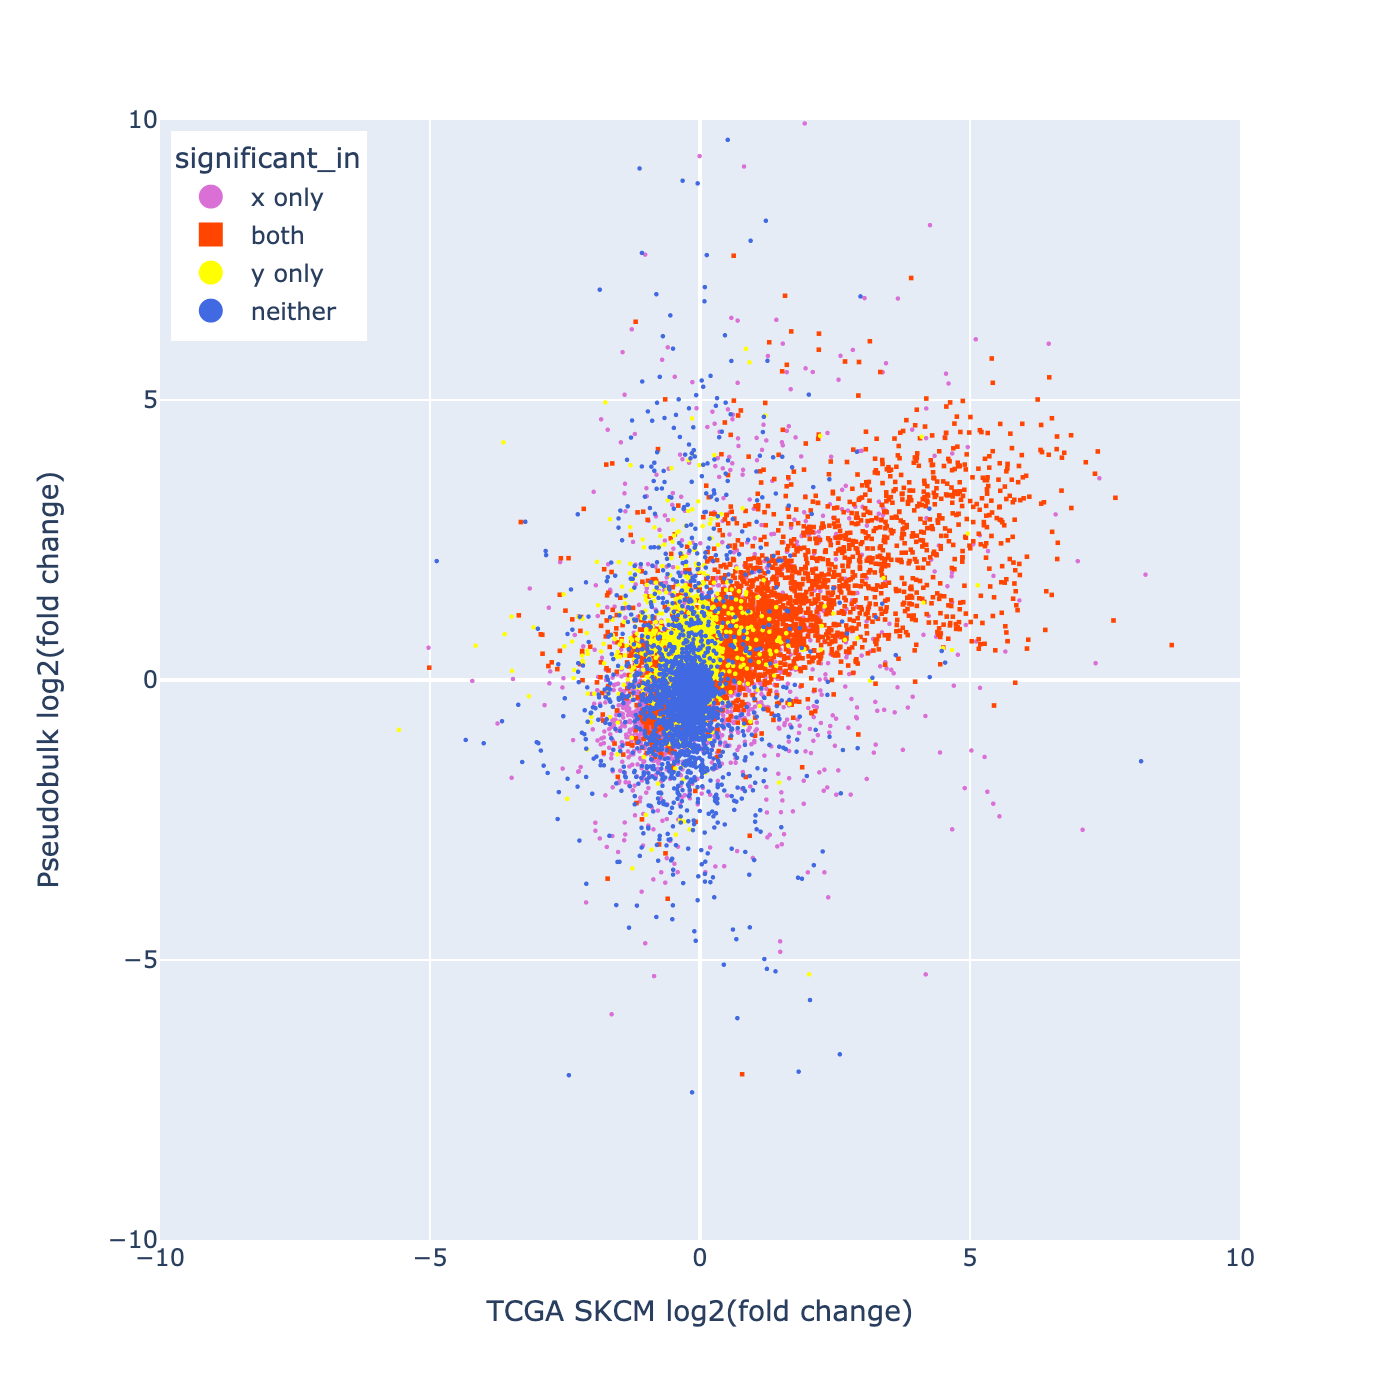

In [164]:
importlib.reload(deg_analysis)

title = "Scatter plot of gene expression fold changes: pseudobulks vs tcga skcm bulk RNA-seq"
fig = deg_analysis.make_scatter_of_log2_fold_changes(
    df_gene_stats_tcga_skcm, df_gene_stats_pseudobulks
)

fig.update_layout(
    # title=title,
    xaxis_title="TCGA SKCM log2(fold change)",
    yaxis_title="Pseudobulk log2(fold change)",
)

print(title)

fig.show(renderer="png", scale=2, width=700, height=700)
# fig.show("browser")

# what's the overlap for significant genes between real, pseudo?

In [92]:
alpha = 0.1

significance_column = f"significant_bh_fdr={alpha:3.2f}"

crosstab = pd.crosstab(
    df_gene_stats_tcga_skcm[significance_column],
    df_gene_stats_pseudobulks[significance_column],
)
odds_ratio, p_value = scipy.stats.fisher_exact(crosstab)
print()

print(odds_ratio)
print("pval:", p_value)
print("-log10(pval):", -np.log10(p_value))
crosstab


1.4771889150215585
pval: 1.3020550266909049e-34
-log10(pval): 33.88537066147963


significant_bh_fdr=0.10,False,True
significant_bh_fdr=0.10,,
False,3886,3382
True,3848,4947
